In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [0]:
!ls

sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('drive/My Drive/data/finaldataset.csv')


negative = df[df['value'] < 0]
positive = df[df['value'] > 0]
neutral  = df[df['value'] == 0]


In [0]:
df.head()

,data,title_x,title_y,title,value,tag
0,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন।,-1,-1,2,-1,কিছুটা নেতিবাচক
1,এটা কেন হচ্ছে? সংশ্লিষ্ট সকলের ডিপ্রেশনের ফলে?...,-1,-1,-1,-1,কিছুটা নেতিবাচক
2,আমাদের দেশের স্বাভাবিক অর্থনৈতিক গতিপ্রবাহকে ব...,-1,-2,-2,-5,নিশ্চিত নেতিবাচক
3,চুরি নয় লুটপাট।,-2,-2,-2,-6,নিশ্চিত নেতিবাচক
4,ইসলামী ব্যাংকের বর্তমান অবস্থা দেখে মনে হয় শাস...,0,-1,0,0,নিরপেক্ষ


In [0]:

negative2 = set (negative.data)
positive2 = set (positive.data)
neutral2 = set(neutral.data)



In [0]:
pos = []
cnt = 0
for s in positive2:
    if len(s.split()) <= 20:
        pos.append(s)
        cnt = cnt + 1


positive2 = pos*2
cnt*2

4816

In [0]:
neg = []
cnt = 0
for s in negative2:
    if len(s.split()) <= 20:
        neg.append(s)
        cnt = cnt + 1


negative2 = neg
cnt

4664

In [0]:
neu = []
cnt = 0
for s in neutral2:
    if len(s.split()) <= 20:
        neu.append(s)
        cnt = cnt + 1


neutral2 = neu*2
cnt*2

4158

**Start**

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
%matplotlib inline

In [0]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [0]:
import random
dataPOS = random.sample(positive2,2300) 
dataNEG = random.sample(negative2,2300)
dataNEU = random.sample(neutral2, 2000)

In [0]:
import nltk
nltk.download('punkt')
SEQ_LENGTH = 22
trainPOS = []
trainNEG = []
trainNEU = []



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
for t in dataPOS:
    t0 = t
    t0 = t0.replace("<br>","")
    t0 = t0.replace("/","")
    token0 = nltk.word_tokenize(t0)
   
    
    if len(token0)>=SEQ_LENGTH:
        token0= token0[:SEQ_LENGTH-1]
    token0.append("<EOS>")

    while len(token0)<SEQ_LENGTH:
        token0.append('<PAD>')
    
    trainPOS.append([token0,token0,1])

In [0]:
for t in dataNEG:
    t0 = t
    t0 = t0.replace("<br>","")
    t0 = t0.replace("/","")
    token0 = nltk.word_tokenize(t0)
   
    
    if len(token0)>=SEQ_LENGTH:
        token0= token0[:SEQ_LENGTH-1]
    token0.append("<EOS>")

    while len(token0)<SEQ_LENGTH:
        token0.append('<PAD>')
    
    trainNEG.append([token0,token0,0])

In [0]:
# trainNEG

In [0]:
for t in dataNEU:
    t0 = t
    t0 = t0.replace("<br>","")
    t0 = t0.replace("/","")
    token0 = nltk.word_tokenize(t0)
   
    
    if len(token0)>=SEQ_LENGTH:
        token0= token0[:SEQ_LENGTH-1]
    token0.append("<EOS>")

    while len(token0)<SEQ_LENGTH:
        token0.append('<PAD>')
    
    trainNEU.append([token0,token0,0])

In [0]:
word2index={"<PAD>":0,"<SOS>":1,"<EOS>":2,"<UNK>":3}

for t in trainPOS:
    for token in t[0]:
        if token not in word2index:
            word2index[token]=len(word2index)



for t in trainNEG:
    for token in t[0]:
        if token not in word2index:
            word2index[token]=len(word2index)


for t in trainNEU:
    for token in t[0]:
        if token not in word2index:
            word2index[token]=len(word2index)

index2word = {v:k for k,v in word2index.items()}

In [0]:
word2index

In [0]:
def prepare_sequence(seq, to_ix):
    idxs = list(map(lambda w: to_ix[w] if w in to_ix.keys() else to_ix["<UNK>"], seq))
    tensor = Variable(torch.LongTensor(idxs)).cuda() if USE_CUDA else Variable(torch.LongTensor(idxs))
    return tensor


flatten = lambda l: [item for sublist in l for item in sublist]

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size,latent_size=10,n_layers=1):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.Wmu= nn.Linear(hidden_size,latent_size)
        self.Wsigma = nn.Linear(hidden_size,latent_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,batch_first=True)
    
    def reparametrize(self, mu, log_var):
        """"z = mean + eps * sigma where eps is sampled from N(0, 1)."""
        eps = Variable(torch.randn(mu.size(0), mu.size(1))).cuda() if USE_CUDA else Variable(torch.randn(mu.size(0), mu.size(1)))
        z = mu + eps * torch.exp(log_var/2)    # 2 for convert var to std
        return z
    
    def forward(self, input,train=True):
        hidden = Variable(torch.zeros(self.n_layers, input.size(0), self.hidden_size)).cuda() if USE_CUDA else Variable(torch.zeros(self.n_layers, input.size(0), self.hidden_size))
        
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        mu = self.Wmu(hidden[-1])
        log_var = self.Wsigma(hidden[-1])
        z = self.reparametrize(mu, log_var)
        
        return z,mu,log_var

In [0]:
class Generator(nn.Module):
    def __init__(self, hidden_size, output_size,latent_size=10,code_size=2, n_layers=1):
        super(Generator, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        #self.Wz = nn.Linear(latent_size+code_size,hidden_size)
        self.Wz = nn.Linear(latent_size,hidden_size)
        self.tanh = nn.Tanh()
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        #self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers,batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input,latent,code,lengths,seq_length,training=True):
        

        embedded = self.embedding(input)
        #embedded = self.dropout(embedded)
       
        # h0
        #latent_code = torch.cat((latent,code),1) # z,c
        #hidden = self.tanh(self.Wz(latent_code)).view(self.n_layers,input.size(0),-1) 
        hidden = self.tanh(self.Wz(latent)).view(self.n_layers,input.size(0),-1) 
        decode=[]
        # Apply GRU to the output so far
        for i in range(seq_length):
            
            _, hidden = self.gru(embedded, hidden)
            score = self.out(hidden.view(hidden.size(0)*hidden.size(1),-1))
            softmaxed = F.log_softmax(score)
            decode.append(softmaxed)
            _,input = torch.max(softmaxed,1)
            embedded = self.embedding(input.unsqueeze(1))
            #embedded = self.dropout(embedded)
        
        # time-step column-wise concat, reshape!!
        scores = torch.cat(decode,1)
        
        return scores.view(input.size(0)*seq_length,-1)

In [0]:
class  Discriminator(nn.Module):
    
    def __init__(self, embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout):
        super(Discriminator,self).__init__()
        #self.args = args
        
        V = embed_num # num of vocab
        D = embed_dim # dimenstion of word vector
        C = class_num # num of class
        Ci = 1
        Co = kernel_num # 100
        Ks = kernel_sizes # [3,4,5]

        self.embed = nn.Embedding(V, D)
        #self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        
        # kernal_size = (K,D) 
        
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks)*Co, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3) #(N,Co,W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x


    def forward(self, x,train=True):
        x = self.embed(x) # (N,W,D)
        
        #if self.args.static:
        #    x = Variable(x)

        x = x.unsqueeze(1) # (N,Ci,W,D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)


        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        if train:
            x = self.dropout(x) # (N,len(Ks)*Co)
        logit = self.fc1(x) # (N,C)
        return logit

In [0]:
HIDDEN_SIZE = 300
LATENT_SIZE = 10
CODE_SIZE = 2
BATCH_SIZE=32
STEP=100
KTA = 0.0
LEARNING_RATE=0.001

In [0]:
encoder =  Encoder(len(word2index), HIDDEN_SIZE,LATENT_SIZE, 2)
generatorPOS = Generator(HIDDEN_SIZE,len(word2index),LATENT_SIZE,CODE_SIZE)
generatorNEG = Generator(HIDDEN_SIZE,len(word2index),LATENT_SIZE,CODE_SIZE)
generatorNEU = Generator(HIDDEN_SIZE,len(word2index),LATENT_SIZE,CODE_SIZE)


discriminator = Discriminator(len(word2index),100,2,30,[3,4,5],0.8)
if USE_CUDA:
    encoder = encoder.cuda()
    generatorPOS = generatorPOS.cuda()
    generatorNEG = generatorNEG.cuda()
    generatorNEU = generatorNEU.cuda()


    discriminator = discriminator.cuda()
    
Recon = nn.CrossEntropyLoss(ignore_index=0)


enc_optim= torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
gen_optimPOS = torch.optim.Adam(generatorPOS.parameters(),lr=LEARNING_RATE)
gen_optimNEG = torch.optim.Adam(generatorNEG.parameters(),lr=LEARNING_RATE)
gen_optimNEU = torch.optim.Adam(generatorNEU.parameters(),lr=LEARNING_RATE)


dis_optiom = torch.optim.Adam(discriminator.parameters(),lr=LEARNING_RATE)

In [0]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        x,y,c = zip(*batch)
        x,y,c = torch.cat(x),torch.cat(y),torch.cat(c)
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        
        yield (x,y,c)

In [0]:
def TRAIN(train, encoder, generator, enc_optom, gen_optim):
    
    elboloss = []
    reconloss = []
    kldloss = []
    
    train_x=[]
    train_y=[]
    code_labels=[]
    lengths=[]
    for tr in train:
        temp = prepare_sequence(tr[0], word2index)
        temp = temp.view(1,-1)
        train_x.append(temp)

        temp2 = prepare_sequence(tr[1],word2index)
        temp2 = temp2.view(1,-1)
        train_y.append(temp2)

        length = [t for t in tr[1] if t !='<PAD>']
        lengths.append(len(length))
        code_labels.append(Variable(torch.LongTensor([int(tr[2])])).cuda() if USE_CUDA else Variable(torch.LongTensor([int(tr[2])])))

    
    train_data = list(zip(train_x,train_y,code_labels))
    
    
    for step in range(STEP):
        for i,(x,y,c) in enumerate(getBatch(BATCH_SIZE,train_data)):

            encoder.zero_grad()
            generator.zero_grad()

            generator_input = Variable(torch.LongTensor([[word2index['<SOS>']]*BATCH_SIZE])).transpose(1,0)

            if USE_CUDA:
                generator_input = generator_input.cuda()

            latent, mu, log_var = encoder(x)

            code = Variable(torch.randn([BATCH_SIZE,2]).uniform_(0,1)).cuda() if USE_CUDA else Variable(torch.randn([BATCH_SIZE,2]).uniform_(0,1))

            score = generator(generator_input,latent,code,lengths,SEQ_LENGTH)
            recon_loss=Recon(score,y.view(-1))
            kld_loss = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))

        #     KL_COST_ANNEALING
            cost_annealing_check = recon_loss.data.cpu().numpy() if USE_CUDA else recon_loss.data.numpy()
            if cost_annealing_check<1.5:
                KTA = 0.5 # KL cost term annealing
            elif cost_annealing_check<1.0:
                KTA = 0.75
            elif cost_annealing_check<0.5:
                KTA = 1.0
            else:
                KTA = 0.0

            ELBO = recon_loss+KTA*kld_loss

            ELBO.backward()

            torch.nn.utils.clip_grad_norm(encoder.parameters(), 5.0)
            torch.nn.utils.clip_grad_norm(generator.parameters(), 5.0)

            gen_optim.step()
            enc_optim.step()

        # KL term Anealing
        #KTA+=1/STEP
        #KTA = round(KTA,3)

        if step % 1==0:
            elbo_for_print = ELBO.data.cpu().numpy() if USE_CUDA else ELBO.data.numpy()
            recon_for_print = recon_loss.data.cpu().numpy() if USE_CUDA else recon_loss.data.numpy()
            kld_for_print = kld_loss.data.cpu().numpy() if USE_CUDA else kld_loss.data.numpy()
            print("[%d/%d] ELBO : %.4f , RECON : %.4f & KLD : %.4f" % (step,STEP,elbo_for_print,
                                                                                  recon_for_print,
                                                                                  kld_for_print))
            elboloss.append(elbo_for_print)
            reconloss.append(recon_for_print)
            kldloss.append(kld_for_print)
    
    
    plt.plot(elboloss)
    plt.plot(reconloss)
    plt.title('ELBO + Recon(NEG)')
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.legend(['ElboLoss', 'ReconLoss'], loc='upper left')
    plt.show()
    plt.savefig('ELRCneg' + '.png')
    
    
    plt.plot(kldloss)
    plt.title('KLD(NEG)')
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.legend(['KldLoss'], loc='upper left')
    plt.show()
    plt.savefig('KLDneg' + '.png')

    
    
    
    return encoder, generator

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


[0/100] ELBO : 7.5597 , RECON : 7.5597 & KLD : 2298.0903
[1/100] ELBO : 7.3488 , RECON : 7.3488 & KLD : 1918.8770
[2/100] ELBO : 7.1540 , RECON : 7.1540 & KLD : 2853.0054
[3/100] ELBO : 7.0536 , RECON : 7.0536 & KLD : 3581.8940
[4/100] ELBO : 6.6691 , RECON : 6.6691 & KLD : 5102.7080
[5/100] ELBO : 6.2752 , RECON : 6.2752 & KLD : 6292.1553
[6/100] ELBO : 6.2082 , RECON : 6.2082 & KLD : 7168.6768
[7/100] ELBO : 5.7048 , RECON : 5.7048 & KLD : 8692.6055
[8/100] ELBO : 5.5653 , RECON : 5.5653 & KLD : 9565.6641
[9/100] ELBO : 5.7127 , RECON : 5.7127 & KLD : 10348.2207
[10/100] ELBO : 5.2010 , RECON : 5.2010 & KLD : 11693.1211
[11/100] ELBO : 4.9771 , RECON : 4.9771 & KLD : 11658.5586
[12/100] ELBO : 5.0607 , RECON : 5.0607 & KLD : 13403.7549
[13/100] ELBO : 4.8769 , RECON : 4.8769 & KLD : 14227.6348
[14/100] ELBO : 4.7305 , RECON : 4.7305 & KLD : 15353.7109
[15/100] ELBO : 4.5534 , RECON : 4.5534 & KLD : 15973.0518
[16/100] ELBO : 4.4241 , RECON : 4.4241 & KLD : 17198.7148
[17/100] ELBO : 

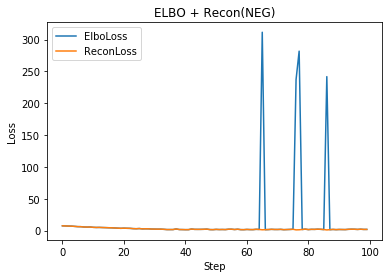

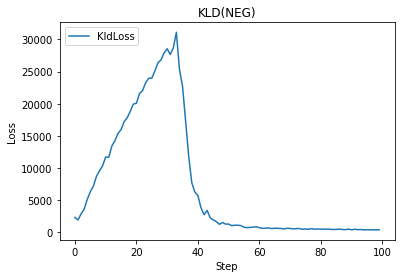

<Figure size 432x288 with 0 Axes>

In [0]:
encoder, generatorPOS = TRAIN(trainPOS, encoder, generatorPOS, enc_optim, gen_optimPOS)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


[0/100] ELBO : 7.9930 , RECON : 7.9930 & KLD : 467.5630
[1/100] ELBO : 7.2805 , RECON : 7.2805 & KLD : 477.4447
[2/100] ELBO : 6.8862 , RECON : 6.8862 & KLD : 550.2107
[3/100] ELBO : 6.2847 , RECON : 6.2847 & KLD : 629.8143
[4/100] ELBO : 6.2142 , RECON : 6.2142 & KLD : 715.4745
[5/100] ELBO : 6.0646 , RECON : 6.0646 & KLD : 843.2277
[6/100] ELBO : 6.0948 , RECON : 6.0948 & KLD : 946.2809
[7/100] ELBO : 5.6586 , RECON : 5.6586 & KLD : 1015.1996
[8/100] ELBO : 5.4361 , RECON : 5.4361 & KLD : 1169.7783
[9/100] ELBO : 5.3160 , RECON : 5.3160 & KLD : 1256.4299
[10/100] ELBO : 5.0355 , RECON : 5.0355 & KLD : 1352.0007
[11/100] ELBO : 4.6265 , RECON : 4.6265 & KLD : 1440.4095
[12/100] ELBO : 4.4648 , RECON : 4.4648 & KLD : 1566.1570
[13/100] ELBO : 4.3479 , RECON : 4.3479 & KLD : 1676.6935
[14/100] ELBO : 3.9477 , RECON : 3.9477 & KLD : 1763.6750
[15/100] ELBO : 3.9542 , RECON : 3.9542 & KLD : 1889.7024
[16/100] ELBO : 3.5174 , RECON : 3.5174 & KLD : 2029.6917
[17/100] ELBO : 3.5198 , RECON 

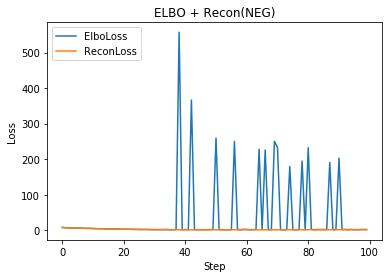

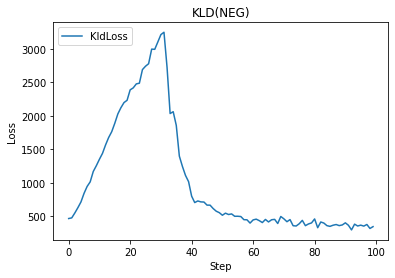

<Figure size 432x288 with 0 Axes>

In [0]:
encoder, generatorNEG = TRAIN(trainNEG, encoder, generatorNEG, enc_optim, gen_optimNEG)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


[0/100] ELBO : 7.5937 , RECON : 7.5937 & KLD : 306.1786
[1/100] ELBO : 7.0732 , RECON : 7.0732 & KLD : 352.7242
[2/100] ELBO : 6.6504 , RECON : 6.6504 & KLD : 418.4734
[3/100] ELBO : 6.1446 , RECON : 6.1446 & KLD : 527.7419
[4/100] ELBO : 6.0324 , RECON : 6.0324 & KLD : 639.2608
[5/100] ELBO : 5.3812 , RECON : 5.3812 & KLD : 751.3559
[6/100] ELBO : 5.1483 , RECON : 5.1483 & KLD : 823.8931
[7/100] ELBO : 4.7953 , RECON : 4.7953 & KLD : 935.3976
[8/100] ELBO : 4.4800 , RECON : 4.4800 & KLD : 1054.5249
[9/100] ELBO : 4.3059 , RECON : 4.3059 & KLD : 1141.0081
[10/100] ELBO : 4.0336 , RECON : 4.0336 & KLD : 1232.8566
[11/100] ELBO : 3.5858 , RECON : 3.5858 & KLD : 1311.5463
[12/100] ELBO : 3.3523 , RECON : 3.3523 & KLD : 1413.9666
[13/100] ELBO : 3.1637 , RECON : 3.1637 & KLD : 1460.3264
[14/100] ELBO : 2.7423 , RECON : 2.7423 & KLD : 1540.8755
[15/100] ELBO : 2.7510 , RECON : 2.7510 & KLD : 1597.2977
[16/100] ELBO : 2.5101 , RECON : 2.5101 & KLD : 1699.2253
[17/100] ELBO : 2.2678 , RECON :

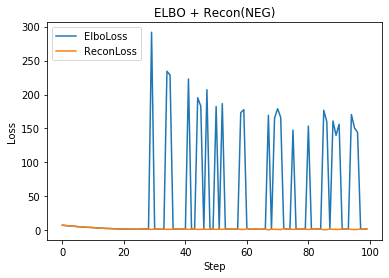

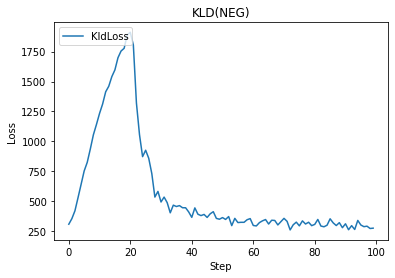

<Figure size 432x288 with 0 Axes>

In [0]:
encoder, generatorNEU = TRAIN(trainNEU, encoder, generatorNEU, enc_optim, gen_optimNEU)

In [0]:
torch.save(generatorPOS.state_dict(),'./generatorPOS.pkl')
torch.save(encoder.state_dict(),'./encoderPOS.pkl')
torch.save(generatorNEG.state_dict(),'./generatorNEG.pkl')
torch.save(generatorNEU.state_dict(),'./generatorNEU.pkl')



In [0]:
generator_input = Variable(torch.LongTensor([[word2index['<SOS>']]*1])).transpose(1,0)
if USE_CUDA:
    generator_input = generator_input.cuda()

latent = Variable(torch.randn([1,10])).cuda() if USE_CUDA else Variable(torch.randn([1,10]))
code = Variable(torch.randn([1,2]).uniform_(0,1)).cuda() if USE_CUDA else Variable(torch.randn([1,2]).uniform_(0,1))
recon = generatorNEG(generator_input,latent,code,15,SEQ_LENGTH,False)

v,i = torch.max(recon,1)

decoded=[]
for t in range(i.size()[0]):
    decoded.append(index2word[i.data.cpu().numpy()[t] if USE_CUDA else i.data.cpu().numpy()[t]])
# print(decoded)

print('A: ', ' '.join([i for i in decoded if i !='<PAD>' and i != '<EOS>'])+'\n')

A:  পুতিনের হাতে মরণাস্ত্র ! ট্রাম্পের হাত তাহলে ফুল দিয়ে কি !



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def generate(encoder, generator, text):
    
    t0 = text
    t0 = t0.replace("<br>","")
    t0 = t0.replace("/","")
    token0 = nltk.word_tokenize(t0)
   
    
    if len(token0)>=SEQ_LENGTH:
        token0= token0[:SEQ_LENGTH-1]
    token0.append("<EOS>")

    while len(token0)<SEQ_LENGTH:
        token0.append('<PAD>')
    
    
    temp = prepare_sequence(token0, word2index)
    temp = temp.view(1,-1)
    
    generator_input = Variable(torch.LongTensor([[word2index['<SOS>']]*1])).transpose(1,0)
    if USE_CUDA:
        generator_input = generator_input.cuda()
    
    
    latent, mu, log_var = encoder(temp)
    
    code = Variable(torch.randn([1,2]).uniform_(0,1)).cuda() if USE_CUDA else Variable(torch.randn([1,2]).uniform_(0,1))
    recon = generator(generator_input,latent,code,15,SEQ_LENGTH,False)

    v,i = torch.max(recon,1)

    decoded=[]
    for t in range(i.size()[0]):
        decoded.append(index2word[i.data.cpu().numpy()[t] if USE_CUDA else i.data.cpu().numpy()[t]])
        
    
    print(text)

    print('A: ', ' '.join([i for i in decoded if i !='<PAD>' and i != '<EOS>'])+'\n')
    
    
    

In [0]:
random.randrange(1, 2000)

233

In [0]:
for i in range(5):
    gen = generate(encoder, generatorPOS, dataNEU[random.randrange(1, 2000)])


# nextgen = generate(encoder, generatorPOS, str(gen))
# print(nextgen)

সকল ধর্মের নাকি শুধু মুসলিমদের।
A:  সুন্দর সুন্দর কিল পড়লে সবারই ক্রিকেটের শুদ্ধ করতে

ওটা এ দেশে স্বাভাবিক দাদা
A:  মন উচিত বাংলাদেশ। করা উচিত। করে।

অনেক বাংলাদেশী ভারতীয় ক্রিকেট এর সমর্থক, তারাই নাম গোপন করে মন্তব্য করে ।
A:  তবে যে , , , দেশ নির্বাচন , , ও রাজস্য আয় , ভাল

আরে মিয়া না জেনে কথা বলবেন না। ধোনির রান ১০১৪৩ শুধু ওয়ানডেতে। টেস্টে ৪৮৭৬ রান বুঝছেন?
A:  এ ধরনের কত নিয়ে মন্তব্য , তার ! তো তার ? সেতু। তাও করেছে

হাজার হাজার কোটি টাকা লুটপাট করলে টাকা থাকবে কি করে?
A:  এ ধরনের ম্যান্ডেট নিয়ে আপত্তিকর , বর্ণবাদী ও নিন্দনীয়।



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
generate(encoder, generatorPOS, "এটা সময় মনে হচ্ছে এখানে একটু পরেই যুদ্ধ")

এটা সময় মনে হচ্ছে এখানে একটু পরেই যুদ্ধ
A:  টুকি বাবু। অনেক এগিয়ে হও। আর ভালো মানুষ হও।



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
grr = ['some', 'thing']
grr = grr*2
grr

['some', 'thing', 'some', 'thing']